In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import binned_statistic,binned_statistic_2d
from rfpimp import plot_corr_heatmap
from sklearn.metrics import confusion_matrix
from gahaco.features.feature_utils import get_data
from gahaco.features.correlation import select_uncorrelated_features
from gahaco.visualization.visualize import rename_features
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict


Using TensorFlow backend.


In [64]:
import matplotlib.font_manager
import matplotlib as mpl
mpl.style.use('~/StreamingModel/streaming/utils/mplstyle')

In [2]:
features_df = pd.read_hdf('/cosma7/data/dp004/dc-cues1/tng_dataframes/merged_dataframe_300.h5')

In [3]:
features_df = features_df.fillna(-9999)
features_df = features_df.replace([-np.inf, np.inf], 0.)

In [4]:
features_df.columns

Index(['ID_DMO', 'm2500c', 'vrms_2500c', 'vrms_std_2500c', 'beta2500c',
       'concentration_prada', 'concentration_nfw', 'rho_s', 'chisq_nfw',
       'vrms_200c', 'vrms_std_200c', 'beta200c', 'N_subhalos',
       'Group_R_Crit200', 'CentralVelDisp', 'CentralVmax', 'Spin',
       'fsub_unbound', 'x_offset', 'CentralHalfmassRad', 'CentralMassInMaxRad',
       'CentralMass', 'env_5', 'env_10', 'haas_1', 'x_dmo', 'y_dmo', 'z_dmo',
       'ID_HYDRO', 'M200_DMO', 'M200_HYDRO', 'Formation Time', 'Nmergers',
       'total_M_stars', 'x_hydro', 'y_hydro', 'z_hydro', 'displacement',
       'N_gals', 'M_stars_central'],
      dtype='object')

In [5]:
RENAME_DICT = { 
        "m2500c": r"$M_{2500c}$",
        "beta2500c": r"$\beta_{v,2500c}$",
        "beta200c": r"$\beta_{v,200c}$",
        "concentration_prada": r"$c$",
        "concentration_nfw": r"$c_{NFW}$",
        "rho_s": r"$\rho_s$",
        "chisq_nfw": r"$\chi^2_{NFW}$",
        "N_subhalos": r"$N_\mathrm{subhalos}$",
        "Group_R_Crit200": r"$R_{200c}$",
        "CentralVelDisp": r"$\sigma_v$",
        "CentralVmax": r"$V_{\mathrm{max}}$",
        "Spin": r"$\lambda$",
        "fsub_unbound": r"$M_{\mathrm{unbound}}$",
        "x_offset": "$x_{\mathrm{offset}}$",
        "CentralHalfmassRad": "$r_{1/2}$",
        "CentralMass":  r"$M_{200c,  \mathrm{central}}$",
        "env_5":  r"$\Delta M_{5}$",
        "haas_1":  r"$D_{1,1}$",
        "M200_DMO":  r"$M_{200c, \mathrm{group}}$",
        "Formation Time":  r"$\tau$",
        "Nmergers":  r"$N_{\mathrm{mergers}}$",

}


In [6]:
drop_columns = ['ID_DMO',
                'ID_HYDRO', 
                'M200_HYDRO',
                'x_dmo',
                'y_dmo',
                'z_dmo',
                'total_M_stars',
                'x_hydro', 
                'y_hydro',
                'z_hydro',
                'N_gals',
                'M_stars_central',
                'vrms_2500c',
                'vrms_200c',
                'vrms_std_200c',
                'vrms_std_2500c',
                'CentralMassInMaxRad',
                'displacement',
                'env_10']

m_stars = features_df.M_stars_central
features_df = features_df.drop(columns=drop_columns)

feature_names = [RENAME_DICT.get(c, c) for c in features_df.columns]

In [7]:
#gini_importances = np.loadtxt(f'../models/lightgbm/gini_importances.csv')
#uncorrelated_df = select_uncorrelated_features(features_df, gini_importances)

In [8]:
method='average'
distance_cutoff=0.25


corr = np.round(spearmanr(features_df).correlation, 4)
corr_condensed = hierarchy.distance.squareform(1-corr)
corr_linkage = hierarchy.linkage(corr_condensed, method=method)
cluster_ids = hierarchy.fcluster(corr_linkage, distance_cutoff, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

In [9]:
# Correltion of each feature with stellar mass
corr_stars = []
for feature in features_df.columns:
    corr_ = spearmanr(features_df[feature], m_stars).correlation
    corr_stars.append(corr_)
    #print(f'{feature} : {corr_:.3f}')
corr_stars = np.asarray(corr_stars)

In [10]:
selected_features = [v[np.argmax(corr_stars[v])]  for v in cluster_id_to_feature_ids.values()]

In [11]:
features_df.columns[selected_features]

Index(['CentralVmax', 'beta2500c', 'concentration_prada', 'chisq_nfw',
       'beta200c', 'CentralHalfmassRad', 'Spin', 'fsub_unbound', 'x_offset',
       'env_5', 'haas_1', 'Formation Time', 'Nmergers'],
      dtype='object')

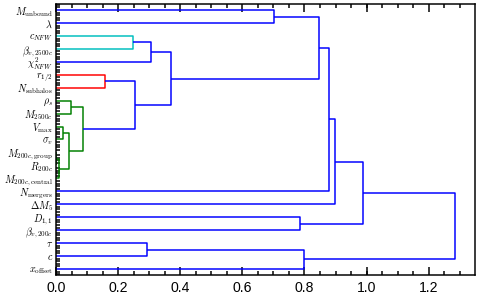

In [71]:
fig, ax = plt.subplots() 
dendro = hierarchy.dendrogram(corr_linkage,
                        labels=[RENAME_DICT.get(c, c) for c in features_df.columns], ax=ax,
                                        leaf_rotation=0,orientation='right', color_threshold=distance_cutoff)
#ax.axvline(x=distance_cutoff, color='black', linestyle='dashed')
plt.savefig('/cosma/home/dp004/dc-cues1/GaHaCo/reports/figures/dendrogram.eps', format='eps')
fig.savefig('/cosma/home/dp004/dc-cues1/GaHaCo/reports/figures/dendrogram.png', format='png', dpi=500)


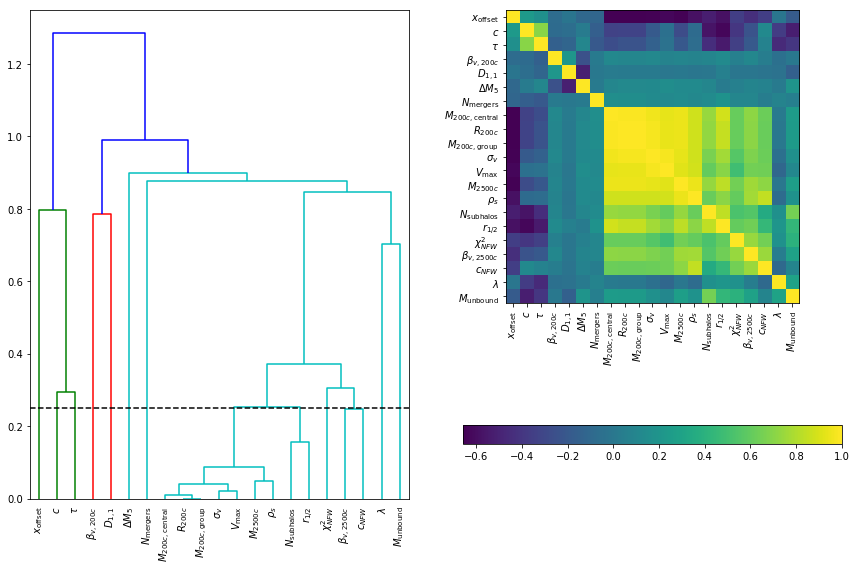

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8)) 
dendro = hierarchy.dendrogram(corr_linkage,
                        labels=[RENAME_DICT.get(c, c) for c in features_df.columns], ax=ax1,
                                        leaf_rotation=90)
ax1.axhline(y=distance_cutoff, color='black', linestyle='dashed')
dendro_idx = np.arange(0, len(dendro['ivl']))


im = ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
fig.colorbar(im, orientation='horizontal', pad = 0.25)
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels([RENAME_DICT.get(c, c) for c in dendro['ivl']], rotation='vertical')
ax2.set_yticklabels([RENAME_DICT.get(c, c) for c in dendro['ivl']])
fig.tight_layout()

In [13]:
selected_df = features_df[features_df.columns[selected_features]]
corr_selected = np.round(spearmanr(selected_df).correlation, 4)


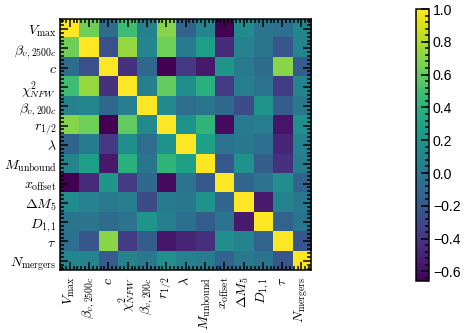

In [66]:
fig, ax = plt.subplots()

ax.imshow(corr_selected)
ax.set_xticks(np.arange(0,len(selected_df.columns)))
ax.set_yticks(np.arange(0,len(selected_df.columns)))

ax.set_xticklabels([RENAME_DICT.get(c, c) for c in selected_df.columns], rotation='vertical')
ax.set_yticklabels([RENAME_DICT.get(c, c) for c in selected_df.columns])
fig.colorbar(im, orientation='vertical', pad = 0.25)


[Text(0,0.5,'$x_{\\mathrm{offset}}$'),
 Text(0,1.5,'$c$'),
 Text(0,2.5,'$\\tau$'),
 Text(0,3.5,'$\\beta_{v,200c}$'),
 Text(0,4.5,'$D_{1,1}$'),
 Text(0,5.5,'$\\Delta M_{5}$'),
 Text(0,6.5,'$N_{\\mathrm{mergers}}$'),
 Text(0,7.5,'$M_{200c,  \\mathrm{central}}$'),
 Text(0,8.5,'$R_{200c}$'),
 Text(0,9.5,'$M_{200c, \\mathrm{group}}$'),
 Text(0,10.5,'$\\sigma_v$'),
 Text(0,11.5,'$V_{\\mathrm{max}}$'),
 Text(0,12.5,'$M_{2500c}$'),
 Text(0,13.5,'$\\rho_s$'),
 Text(0,14.5,'$N_\\mathrm{subhalos}$'),
 Text(0,15.5,'$r_{1/2}$'),
 Text(0,16.5,'$\\chi^2_{NFW}$'),
 Text(0,17.5,'$\\beta_{v,2500c}$'),
 Text(0,18.5,'$c_{NFW}$'),
 Text(0,19.5,'$\\lambda$'),
 Text(0,20.5,'$M_{\\mathrm{unbound}}$')]

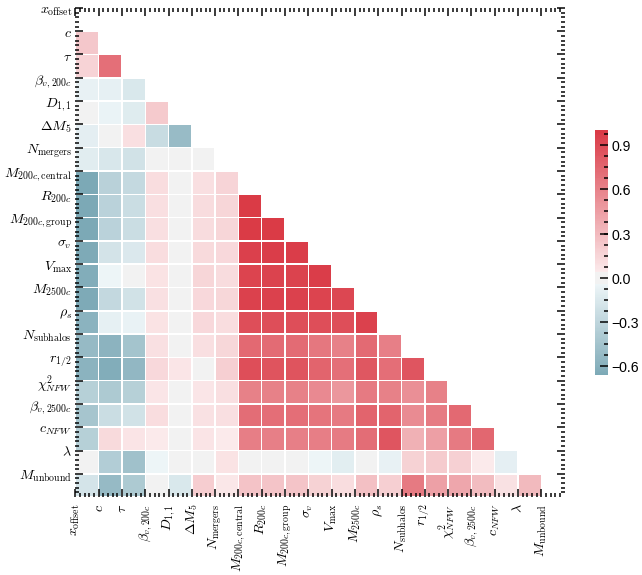

In [67]:
im = ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
fig.colorbar(im, orientation='horizontal', pad = 0.25)
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels([RENAME_DICT.get(c, c) for c in dendro['ivl']], rotation='vertical')
ax2.set_yticklabels([RENAME_DICT.get(c, c) for c in dendro['ivl']])
fig.tight_layout()

import seaborn as sns

mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr[dendro['leaves'], :][:, dendro['leaves']], mask=mask, cmap=cmap, vmax=1., center=0.,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
           annot=False)
ax.set_xticks(dendro_idx)
ax.set_yticks(dendro_idx)

ax.set_xticklabels([RENAME_DICT.get(c, c) for c in dendro['ivl']], rotation='vertical')
ax.set_yticklabels([RENAME_DICT.get(c, c) for c in dendro['ivl']], rotation='horizontal')


[Text(0,0.5,'$V_{\\mathrm{max}}$'),
 Text(0,1.5,'$\\beta_{v,2500c}$'),
 Text(0,2.5,'$c$'),
 Text(0,3.5,'$\\chi^2_{NFW}$'),
 Text(0,4.5,'$\\beta_{v,200c}$'),
 Text(0,5.5,'$r_{1/2}$'),
 Text(0,6.5,'$\\lambda$'),
 Text(0,7.5,'$M_{\\mathrm{unbound}}$'),
 Text(0,8.5,'$x_{\\mathrm{offset}}$'),
 Text(0,9.5,'$\\Delta M_{5}$'),
 Text(0,10.5,'$D_{1,1}$'),
 Text(0,11.5,'$\\tau$')]

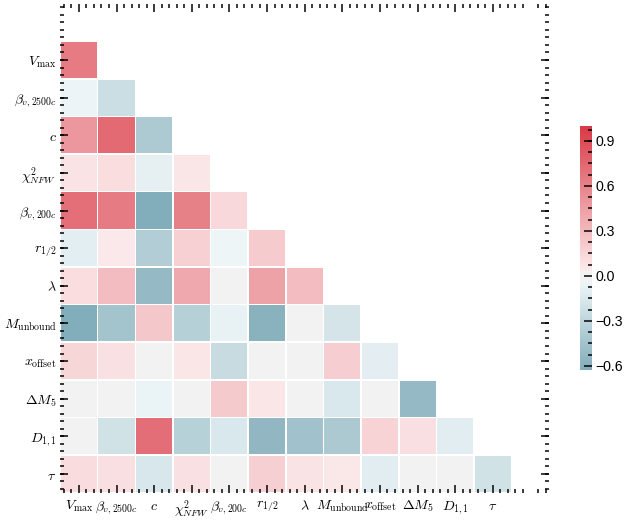

In [68]:
import seaborn as sns

mask = np.triu(np.ones_like(corr_selected, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_selected, mask=mask, cmap=cmap, vmax=1., center=0.,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},#, "location":"top"}, 
           annot=False)
ax.set_xticks(np.arange(0,len(selected_df.columns)-1)+0.5)
ax.set_yticks(np.arange(1,len(selected_df.columns))+0.5)

ax.set_xticklabels([RENAME_DICT.get(c, c) for c in selected_df.columns][:-1])#, rotation='vertical')
ax.set_yticklabels([RENAME_DICT.get(c, c) for c in selected_df.columns], rotation='horizontal')


(array([1.17873e+05, 6.47730e+04, 1.85350e+04, 4.63800e+03, 9.37000e+02,
        1.97000e+02, 3.60000e+01, 1.20000e+01, 2.00000e+00, 2.00000e+00]),
 array([  3.71583392,  24.02788893,  44.33994393,  64.65199894,
         84.96405395, 105.27610896, 125.58816397, 145.90021898,
        166.21227399, 186.52432899, 206.836384  ]),
 <a list of 10 Patch objects>)

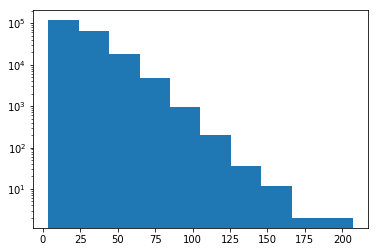

In [15]:
plt.hist(features_df.haas_1[features_df.haas_1 < 1000], log=True)

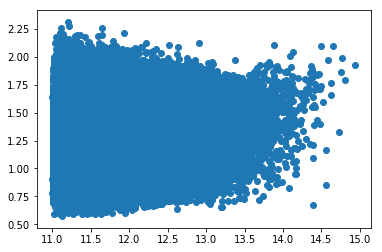

In [16]:
plt.scatter(np.log10(features_df.M200_DMO[features_df.haas_1 < 1000]),
            np.log10(features_df.haas_1[features_df.haas_1 < 1000]))

In [17]:
features_df.columns

Index(['m2500c', 'vrms_2500c', 'vrms_std_2500c', 'beta2500c',
       'concentration_prada', 'concentration_nfw', 'rho_s', 'chisq_nfw',
       'vrms_200c', 'vrms_std_200c', 'beta200c', 'N_subhalos',
       'Group_R_Crit200', 'CentralVelDisp', 'CentralVmax', 'Spin',
       'fsub_unbound', 'x_offset', 'CentralHalfmassRad', 'CentralMassInMaxRad',
       'CentralMass', 'env_5', 'env_10', 'haas_1', 'M200_DMO',
       'Formation Time', 'Nmergers', 'displacement'],
      dtype='object')

In [18]:
N_gals = m_stars > 1.e9

In [ ]:
features.env_5
features.CentralMass
x,y = np.meshgrid(features.env_5, features.CentralMass)
N_gals
plt.hist2d()

In [110]:
env_bins = np.array([11.,11.5,12.5,13,13.5,14.,16,22])

In [180]:
features_df.CentralMass[np.log10(features_df.CentralMass)<11.8].shape

(158718,)

In [208]:
result = binned_statistic_2d(np.log10(features_df.CentralMass[np.log10(features_df.CentralMass)<11.5]), 
                    features_df.env_5[np.log10(features_df.CentralMass)<11.5],
                    N_gals.astype(np.float)[np.log10(features_df.CentralMass)<11.5],
                    statistic='mean',
                    bins=(10,10))

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [204]:
mass = binned_statistic(np.log10(features_df.CentralMass), 
                          N_gals.astype(np.float),
                          statistic='std',
                       bins=20)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [172]:
mass_center = 0.5*(mass.bin_edges[1:] + mass.bin_edges[:-1])

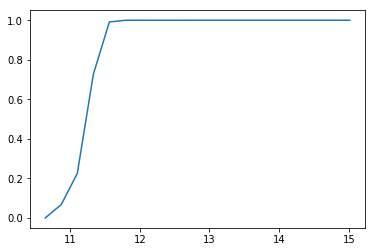

In [173]:
plt.plot(mass_center, mass.statistic)

In [194]:
x_center = 0.5*(result.x_edge[1:] +result.x_edge[:-1])
y_center = 0.5*(result.y_edge[1:] +result.y_edge[:-1])

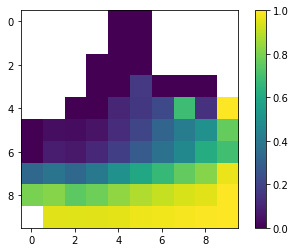

In [210]:
plt.imshow(result.statistic, interpolation='None')
plt.colorbar()